# Image Warping Lab

## Part 1: Interpolation

Since we are going to be warping images, we need to make sure we have a good interpolation function to deal with inexact pixel locations.

In the cell below, we want to scale an image by a factor of 2.30 in both x and y. **Write a function called "interpolate" that performs bilinear interpolation.** This function should take in the image and a location (x,y) of interest. It then uses the nearby pixels to that location to interpolate and return an RGB value.

C:\Users\chant\Anaconda3\envs\cs355env\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


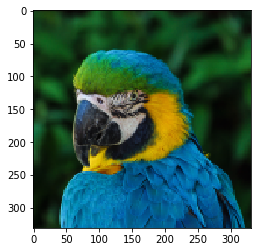

In [29]:
from scipy.ndimage import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imsave
import math

#Your bilinear interpolation function
def interpolate(image, row, column):
    finalArray = [0., 0., 0.] 
    
    col_decimal = column - math.floor(column)
    row_decimal = row - math.floor(row)
    
    h,w,_ = image.shape
    
    if math.ceil(row) < h and math.ceil(column) < w and math.floor(row) >= 0 and math.floor(column) >= 0:
        topLeft = image[math.floor(row)][math.floor(column)]
        bottomLeft = image[math.ceil(row)][math.floor(column)]
        topRight = image[math.floor(row)][math.ceil(column)]
        bottomRight = image[math.ceil(row)][math.ceil(column)]
        
        first = ((1 - row_decimal) * topRight) + (row_decimal * bottomRight)
        second = ((1 - row_decimal) * topLeft) + (row_decimal * bottomLeft)
            
        third = second + (col_decimal * (first - second))
        
        finalArray = third
            
    return finalArray

filename = "test.png"
im = imread(filename)

h,w,_ = im.shape

result = np.zeros((int(2.3*h),(int(2.3*w)),3), dtype="uint8")

#Write code that scales the image by a factor of 2.3
#It should call interpolate.

for row in range(int(h*2.3)):
    for column in range(int(w*2.3)):
        result[row][column] = interpolate(im, int(row/2.3), int(column/2.3))
        
plt.imshow(result,vmin=0)
plt.show()

## Part 2: Backwards Mapping

Now that we have a interpolation function, we need a function that performs a backward mapping between a source and target image.

Given a simple rotation transformation, **write a function that performs a backwards mapping. This function should also call your interpolate function.**

For this example, the source and target image will be the same size, which means part of your rotated image will be cut off on the corners. You can assume that all pixels need to be backward mapped. Also, **don't forget to invert the transform. This is really easy in numpy.**

C:\Users\chant\Anaconda3\envs\cs355env\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


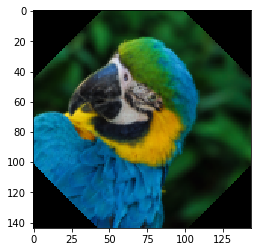

In [28]:
def backmap1(image, transform):
    
    h,w,_ = image.shape
    
    result = np.zeros((h,w,3), dtype="uint8")
    
    inv_transform = np.linalg.inv(transform)
    
    for column in range(w):
        for row in range(h):
            array = np.array([[column], [row], [1]])
            new_point = inv_transform @ array
            result[row][column] = interpolate(image, new_point[1], new_point[0])
    
    return result


from math import sin,cos,pi

filename = "test.png"
im = imread(filename)

transform = np.matrix([[cos(45 * pi/180), -sin(45 * pi/180), w/2],[sin(45 * pi/180),cos(45 * pi/180),-h/5],[0,0,1]])

result = backmap1(im,transform)

plt.imshow(result,vmin=0)
plt.show()


## Part 3: Homographies

Now that we have the two specific functions that we need, let's start looking at some more interesting image warping. In class, we discussed how we can use homographies to warp images nonlinearly. In this lab, we have provided the homography generating code for you. 

In [4]:
class Point():
    def __init__(self,x,y):
        self.x = x
        self.y = y


def getHomography(s0,s1,s2,s3,t0,t1,t2,t3):

    x0s = s0.x
    y0s = s0.y
    x0t = t0.x
    y0t = t0.y

    x1s = s1.x
    y1s = s1.y
    x1t = t1.x
    y1t = t1.y

    x2s = s2.x
    y2s = s2.y
    x2t = t2.x
    y2t = t2.y

    x3s = s3.x
    y3s = s3.y
    x3t = t3.x
    y3t = t3.y

    #Solve for the homography matrix
    A = np.matrix([
            [x0s, y0s, 1, 0, 0, 0, -x0t*x0s, -x0t*y0s],
            [0, 0, 0, x0s, y0s, 1, -y0t*x0s, -y0t*y0s],
            [x1s, y1s, 1, 0, 0, 0, -x1t*x1s, -x1t*y1s],
            [0, 0, 0, x1s, y1s, 1, -y1t*x1s, -y1t*y1s],
            [x2s, y2s, 1, 0, 0, 0, -x2t*x2s, -x2t*y2s],
            [0, 0, 0, x2s, y2s, 1, -y2t*x2s, -y2t*y2s],
            [x3s, y3s, 1, 0, 0, 0, -x3t*x3s, -x3t*y3s],
            [0, 0, 0, x3s, y3s, 1, -y3t*x3s, -y3t*y3s]
        ])

    b = np.matrix([
            [x0t],
            [y0t],
            [x1t],
            [y1t],
            [x2t],
            [y2t],
            [x3t],
            [y3t]
        ])

    #The homorgraphy solutions a-h
    solutions = np.linalg.solve(A,b)

    solutions = np.append(solutions,[[1.0]], axis=0)

    #Reshape the homography into the appropriate 3x3 matrix
    homography = np.reshape(solutions, (3,3))
    
    return homography

def getScreen():
    result = []
    screen = np.loadtxt("screen.txt")
    for line in screen:
        result.append(Point(int(line[0]), int(line[1])))
    return result

We want to be able to get a new image into the tv set in the image shown below. Note that not all pixels will need to be backward mapped. For this reason, we also need to specify a list of points that we are considering. This is provided in the getScreen function definined above.

**Rewrite your backmap function to allow for two images of different sizes and a specific set of points that need to be mapped.**

C:\Users\chant\Anaconda3\envs\cs355env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\chant\Anaconda3\envs\cs355env\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


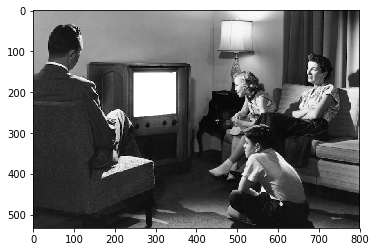

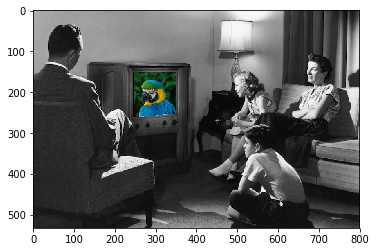

In [5]:
def backmap2(source, target, transform, points):
    
    inv_transform = np.linalg.inv(transform)
    
    for point in points:
        new_point = inv_transform @ [point.x, point.y, 1]
        new_point = np.squeeze(np.asarray(new_point))
        target[point.y][point.x]= interpolate(source, new_point[1], new_point[0])
    
    return target



filename = "test.png"
im = imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-1,0)
s2 = Point(w-1,h-1)
s3 = Point(0,h-1)

t0 = Point(245,152)
t1 = Point(349,150)
t2 = Point(349,253)
t3 = Point(246,261)

tv = imread('tv.jpg')
plt.imshow(tv,vmin=0)
plt.show()

transform = getHomography(s0,s1,s2,s3,t0,t1,t2,t3)

screen = getScreen()

result = backmap2(im, tv, transform, screen)

plt.imshow(result,vmin=0)
plt.show()


## Part 4: Geometric Tests

We have a pretty robust warping algorithm now, but we need a way of determining which pixels are of interest and which pixels are not of interest on our target image.

Notice in the image below that we were able to replace the nearest canvas with a picture of BYU campus. We did so by finding the corners of the canvas, determining points that lie inside that canvas, and then using a homography as our transform for the backward mapping. We left a blank canvas for you to try this out as well. 

**Rewrite your backmap function (yet again) to take in the corners of interest, perform a homography, and include a pixel tester that makes a bounding box around the area of interest, then uses cross product geometric testing to verify if a pixel is on the canvas** (we acknowledge there are other ways you could solve this problem, but this is good practice).


C:\Users\chant\Anaconda3\envs\cs355env\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


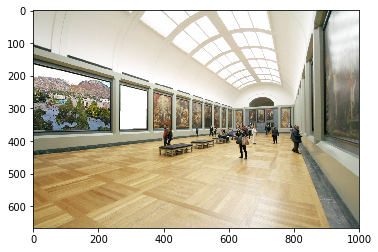

C:\Users\chant\Anaconda3\envs\cs355env\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


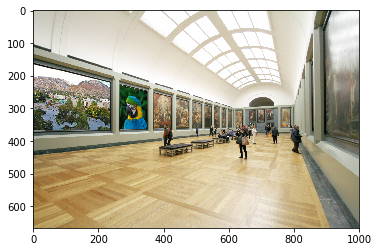

In [25]:
def getCanvas(t0, t1, t2, t3):
    
    canvas = []
    min_x = t0.x
    min_y = t0.y
    max_x = 0
    max_y = 0
    
    points = [t0, t1, t2, t3]

    for point in points:
        if point.x > max_x:
            max_x = point.x
        if point.x < min_x:
            min_x = point.x
        if point.y > max_y:
            max_y = point.y
        if point.y < min_y:
            min_y = point.y
       
    box_points = []        
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            new_point = Point(x, y)
            box_points.append(new_point)
            
    
    t0_arr = np.array([t0.x, t0.y])
    t1_arr = np.array([t1.x, t1.y])
    t2_arr = np.array([t2.x, t2.y])
    t3_arr = np.array([t3.x, t3.y]) 
    points_arr = [t0_arr, t1_arr, t2_arr, t3_arr]
    
    for point in box_points:
        wrap_around = True
        add_point = True
        
        for i in range(len(points_arr)):
            box_arr = np.array([point.x, point.y])
            if wrap_around:
                second = points_arr[-1]
                wrap_around = False
            else:
                second = points_arr[i - 1]   
            first = points_arr[i]
            
            perp = (first - second)
            tmp = perp[0]
            perp[0] = perp[1]
            perp[1] = -tmp
            
            final = np.dot((box_arr - second), perp)
            if final > 0:
                add_point = False
                
        if add_point:
            canvas.append(point)
            
    return canvas


def backmap3(source,target,s0,s1,s2,s3,t0,t1,t2,t3):
    
    transform = getHomography(s0,s1,s2,s3,t0,t1,t2,t3)
    points = getCanvas(t0, t1, t2, t3)
    
    target = backmap2(source, target, transform, points)
    
    return target
    

museum = imread('museum.png')
plt.imshow(museum,vmin=0)
plt.show()

filename = "test.png"
im = imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-1,0)
s2 = Point(w-1,h-1)
s3 = Point(0,h-1)

t0 = Point(268,230)
t1 = Point(349,249)
t2 = Point(348,362)
t3 = Point(267,363)

result = backmap3(im,museum,s0,s1,s2,s3,t0,t1,t2,t3)
    
plt.imshow(result,vmin=0)
plt.show()
